In [2557]:
# pip install pandas-profiling

# Imports

In [2558]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import statistics as stats
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

import scipy.stats as stats

# Load & clean data

## DF New Cases & R (that is the main dataset I work with)

In [2559]:
df = pd.read_csv('Nowcast_R_aktuell, seit Pandemiebeginn.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('.', '', regex=True)

In [2560]:

df.columns

Index(['datum', 'ps_covid_faelle', 'ug_pi_covid_faelle', 'og_pi_covid_faelle',
       'ps_covid_faelle_ma4', 'ug_pi_covid_faelle_ma4',
       'og_pi_covid_faelle_ma4', 'ps_7_tage_r_wert', 'ug_pi_7_tage_r_wert',
       'og_pi_7_tage_r_wert'],
      dtype='object')

In [2561]:
df.drop(['ug_pi_covid_faelle', 'og_pi_covid_faelle', 'ps_covid_faelle_ma4', 'ug_pi_covid_faelle_ma4',
       'og_pi_covid_faelle_ma4', 'ug_pi_7_tage_r_wert',
       'og_pi_7_tage_r_wert'], axis=1, inplace=True)
df.rename(columns={'datum':'date', 'ps_covid_faelle':'cases','ps_7_tage_r_wert':'rval'}, inplace=True)

In [2562]:
# Export cleaned data
#df.to_excel('rval.xlsx', index=False)

In [2563]:
profile = df.profile_report(title='Pandas Profiling Report')
# profile

In [2564]:
df.isna().sum()
df.dropna(inplace=True)

In [2565]:
df = df.reset_index()

In [2566]:
df.dtypes

index      int64
date      object
cases      int64
rval     float64
dtype: object

In [2567]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')


## DF by Region
unfortunately I didn't use this dataframe for further analysis (yet)

by_region = pd.read_csv('RKI_COVID19_Nordrhein-Westfalen.csv', sep=";")
by_region.columns = by_region.columns.str.lower().str.replace(' ', '_').str.replace('.', '', regex=True)
by_region.drop(['idbundesland', 'bundesland', 'idlandkreis', 'altersgruppe', 'altersgruppe2', 'geschlecht', 'refdatum', 'isterkrankungsbeginn', 'neuerfall', 'neuertodesfall', 'neugenesen', 'anzahltodesfall', 'anzahlgenesen', 'datenstand', 'objectid'], axis=1, inplace=True)
by_region.rename(columns={'meldedatum':'date', 'anzahlfall':'cases','landkreis':'region'}, inplace=True)
by_region['date'] = pd.to_datetime(by_region['date'], errors='coerce')


by_region['date'] = by_region['date'].dt.strftime('%m-%d-%Y')

by_region.columns

In [2568]:
# by_region.groupby(['region'])['cases'].agg(sum)

by_region = by_region.groupby(['region', 'date'])['cases'].agg(sum).reset_index()

by_region

In [2569]:
# todo: df: by region
## resorting by date and region
## then run pct.change per region
# by_region['growth'] = by_region['cases'].pct_change()

## DF Hospital cases

In [2570]:
hosp = pd.read_excel('Aktuell_Deutschland_COVID-19-Hospitalisierungen, nach Bundesland, seit März 2021.xlsx')
hosp.columns = hosp.columns.str.lower().str.replace(' ', '_').str.replace('.', '', regex=True)

In [2571]:
hosp.columns

Index(['datum', 'bundesland', 'bundesland_id', 'altersgruppe',
       'fixierte_7t_hospitalisierung_faelle',
       'aktualisierte_7t_hospitalisierung_faelle',
       'ps_adjustierte_7t_hospitalisierung_faelle',
       'ug_pi_adjustierte_7t_hospitalisierung_faelle',
       'og_pi_adjustierte_7t_hospitalisierung_faelle', 'bevoelkerung',
       'fixierte_7t_hospitalisierung_inzidenz',
       'aktualisierte_7t_hospitalisierung_inzidenz',
       'ps_adjustierte_7t_hospitalisierung_inzidenz',
       'ug_pi_adjustierte_7t_hospitalisierung_inzidenz',
       'og_pi_adjustierte_7t_hospitalisierung_inzidenz'],
      dtype='object')

In [2572]:
hosp.drop(['bundesland', 'bundesland_id', 'altersgruppe',
       'fixierte_7t_hospitalisierung_faelle',      
       'ps_adjustierte_7t_hospitalisierung_faelle',
       'ug_pi_adjustierte_7t_hospitalisierung_faelle',
       'og_pi_adjustierte_7t_hospitalisierung_faelle', 'bevoelkerung',
       'fixierte_7t_hospitalisierung_inzidenz',
       'aktualisierte_7t_hospitalisierung_inzidenz',
       'ps_adjustierte_7t_hospitalisierung_inzidenz',
       'ug_pi_adjustierte_7t_hospitalisierung_inzidenz',
       'og_pi_adjustierte_7t_hospitalisierung_inzidenz'], axis=1, inplace=True)
hosp.rename(columns={'datum':'date', 'aktualisierte_7t_hospitalisierung_faelle':'hcases'}, inplace=True)
hosp['date'] = pd.to_datetime(df['date'], errors='coerce')

In [2573]:
hosp = hosp.groupby(['date'])['hcases'].agg(sum)
hosp = hosp.reset_index() 

In [2574]:
hosp.drop(['date'], axis=1, inplace=True)
hosp = pd.concat([df, hosp], axis=1)
hosp.drop(['index'], axis=1, inplace=True)
hosp

,date,cases,rval,hcases
0,2020-03-06,757,2.34,4192
1,2020-03-07,984,2.56,4409
2,2020-03-08,1336,2.93,4670
3,2020-03-09,2020,3.13,4558
4,2020-03-10,2574,3.22,4914
...,...,...,...,...
771,2022-04-16,83543,0.89,118
772,2022-04-17,94915,0.88,130
773,2022-04-18,106658,0.92,128
774,2022-04-19,124049,0.98,138


## DF Corona tests

In [2575]:
tests = pd.read_excel('Testzahlen-gesamt-rki.xlsx', sheet_name="1_Testzahlerfassung")
tests.columns = tests.columns.str.lower().str.replace(' ', '_').str.replace('.', '', regex=True)

In [2576]:
tests.columns

Index(['kalenderwoche', 'anzahl_testungen', 'positiv_getestet',
       'positivenanteil_(%)', 'anzahl_übermittelnder_labore'],
      dtype='object')

In [2577]:
tests.drop(['positiv_getestet', 'anzahl_übermittelnder_labore'], axis=1, inplace=True)

In [2578]:
tests.rename(columns={'kalenderwoche':'date', 'anzahl_testungen':'tests', 'positivenanteil_(%)':'positivity_rate'}, inplace=True)

In [2579]:
tests=tests.drop(tests.index[[0]])

In [2580]:
tests[['week', 'year']] = tests['date'].str.split('/', 1, expand=True)

In [2581]:
tests = tests.dropna()

In [2582]:
tests['year'] = tests['year'].astype(int)
tests['week'] = tests['week'].astype(int)

### calculate amount of tests beginning in ~May

In [2583]:
print('Test 2020: ' + str(tests['tests'][(tests['year'] == 2020) & (tests['week'] >= 19)].sum()))
print('Tests 2021: ' + str(tests['tests'][(tests['year'] == 2021) & (tests['week'] >= 19)].sum()))

p_rate_2020 = tests['positivity_rate'][(tests['year'] == 2020) & (tests['week'] >= 19)].sum()
p_rate_2021 = tests['positivity_rate'][(tests['year'] == 2021) & (tests['week'] >= 19)].sum()

print('Positivity rate 2020: ' + str(p_rate_2020))
print('Positivity rate 2021: ' + str(p_rate_2021))

p_ratio = p_rate_2021 / p_rate_2020

print(p_ratio)


Test 2020: 33304431
Tests 2021: 35269365
Positivity rate 2020: 139.05297652534705
Positivity rate 2021: 304.2448276912411
2.18797781459775


## Some more cleaning on DF New Cases & R

In [2584]:
# I only want to compare 2nd half of 2020 to 2nd half of 2021 
# So I drop all other data
# and because I want to run a test on the cases later I create a copy before that

In [2585]:
# add column year
df['year'] = df['date'].dt.year

# df["date"].dt.strftime("%m-%d")

### Drop data & create copy for t-test

In [2586]:
t_testdata = df.copy()

In [2587]:
df = df.drop(df[((df.date <= '2021-04-30') & (df.date >= '2021-01-01'))].index)
df = df.drop(df[((df.date <= '2020-04-30') & (df.date >= '2020-01-01'))].index)

In [2588]:
df = df.drop(df[df.year == 2022].index)

# Calculate some more data

## Calculate growth of cases and R

In [2589]:
df

,index,date,cases,rval,year
56,60,2020-05-01,814,0.82,2020
57,61,2020-05-02,743,0.85,2020
58,62,2020-05-03,756,0.86,2020
59,63,2020-05-04,891,0.89,2020
60,64,2020-05-05,813,0.90,2020
...,...,...,...,...,...
661,665,2021-12-27,38089,1.09,2021
662,666,2021-12-28,37520,1.13,2021
663,667,2021-12-29,34666,1.15,2021
664,668,2021-12-30,33152,1.17,2021


In [2590]:
df['r_growth'] = df['rval'].pct_change()

In [2591]:
df['c_growth'] = df['cases'].pct_change()

In [2592]:
# Fill empty rows
df['r_growth'].iloc[0] = 0.05
df['c_growth'].iloc[0] = 0.25


C:\Users\TgMiles\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [2593]:
df.iloc[[1,2]]

,index,date,cases,rval,year,r_growth,c_growth
57,61,2020-05-02,743,0.85,2020,0.036585,-0.087224
58,62,2020-05-03,756,0.86,2020,0.011765,0.017497


In [2594]:
# Calculate r-growth mean over a 7 day span
mean_of_x_days = 7 # needs to be an odd number: e.g. 7 means the day itself and 3 days before and after
day_span = int((mean_of_x_days - 1) / 2)

In [2595]:
# df['r_growth'].iloc[0:7].mean()

growth_avg = []
i = 0
for row in df['r_growth']:
    if i < 3:
        growth_avg.append(0)
        i = i+1
    else:
        growth_avg.append(df['r_growth'].iloc[i-day_span:i+day_span].mean())
        i = i+1

In [2596]:
df['growth_avg'] = growth_avg

## Calculate number of consecutive days for r_growth

In [2597]:
#todo: count days with decreasing r_growth
df['rg_cd'] = 0 # consecutive days of r_growth
i = 0
for row in df['r_growth']:
    if i == 0: # skip for i = 0
        df['rg_cd'].iloc[i] = 0
        i = i+1
        continue
    if df['r_growth'].iloc[i] >= 0: # add one day if r_growth >= 0 
        df['rg_cd'].iloc[i] = df['rg_cd'].iloc[i-1] + 1
        i = i+1
    else:
        i = i+1

C:\Users\TgMiles\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Calculate number of days with r_growth >=0  in the last x days

In [2598]:
# (df['r_growth'] == 0).value_counts()

In [2599]:
#todo: does it matter if I chose >= or >
df['rg_30'] = 0 # number of days with r_growth >= 0 in the last 30 days
df['rg_14'] = 0
df['rg_7'] = 0
i = 0
dayspan = 0
for row in df['r_growth']:    
    dayspan = 0 if i-30 <0 else i-30
    df['rg_30'].iloc[i] = (sum(df['r_growth'].iloc[dayspan:i]>0))        
    dayspan = 0 if i-14 <0 else i-14
    df['rg_14'].iloc[i] = (sum(df['r_growth'].iloc[dayspan:i]>0))
    dayspan = 0 if i-7 <0 else i-7
    # print('i: ' + str(i) + ', ds: ' + str(dayspan) + ', v: ' + str(sum(df['r_growth'].iloc[i-7:i]>0)) + ', v: ' + str(sum(df['r_growth'].iloc[dayspan:i]>0)) + '\n' )
    df['rg_7'].iloc[i] = (sum(df['r_growth'].iloc[dayspan:i]>0))        
    i = i+1

# Some basic analysis

## Regarding R

### group by R growth

In [2600]:
print(df['r_growth'][df['year'] == 2020].describe())
print(df['r_growth'][df['year'] == 2021].describe())


count    245.000000
mean       0.001390
std        0.034239
min       -0.201923
25%       -0.017544
50%        0.000000
75%        0.019608
max        0.201681
Name: r_growth, dtype: float64
count    245.000000
mean       0.001111
std        0.019637
min       -0.073684
25%       -0.011628
50%        0.000000
75%        0.012500
max        0.065217
Name: r_growth, dtype: float64


In [2601]:
qbins = pd.qcut(df['r_growth'][df['year'] == 2020],4)
print('2020')
print(qbins.value_counts().sort_index(ascending=True))
print('\n')
print('2021')
qbins = pd.qcut(df['r_growth'][df['year'] == 2021],4)
print(qbins.value_counts().sort_index(ascending=True))


2020
(-0.203, -0.0175]    62
(-0.0175, 0.0]       74
(0.0, 0.0196]        49
(0.0196, 0.202]      60
Name: r_growth, dtype: int64


2021
(-0.0747, -0.0116]    63
(-0.0116, 0.0]        85
(0.0, 0.0125]         36
(0.0125, 0.0652]      61
Name: r_growth, dtype: int64


In [2602]:
min = df['r_growth'][df['year'] == 2020].min()
max = df['r_growth'][df['year'] == 2020].max()
bins = pd.cut(df['r_growth'][df['year'] == 2020],[min, -0.02, 0, 0.02, max])
print('2020')
print(bins.value_counts(dropna=True).sort_index(ascending=True))

min = df['r_growth'][df['year'] == 2021].min()
max = df['r_growth'][df['year'] == 2021].max()
bins = pd.cut(df['r_growth'][df['year'] == 2021],[min, -0.02, 0, 0.02, max])
print('\n')
print('2021')
print(bins.value_counts(dropna=True).sort_index(ascending=True))

# so in avg R increased & decreased slower in 2021 

2020
(-0.202, -0.02]    49
(-0.02, 0.0]       86
(0.0, 0.02]        51
(0.02, 0.202]      58
Name: r_growth, dtype: int64


2021
(-0.0737, -0.02]     27
(-0.02, 0.0]        120
(0.0, 0.02]          64
(0.02, 0.0652]       33
Name: r_growth, dtype: int64


### group by R

In [2603]:
qbins = pd.qcut(df['rval'][df['year'] == 2020],5)
print('2020')
print(qbins.value_counts().sort_index(ascending=True))
print('\n')
print('2021')
qbins = pd.qcut(df['rval'][df['year'] == 2021],5)
print(qbins.value_counts().sort_index(ascending=True))


2020
(0.729, 0.928]    49
(0.928, 1.0]      50
(1.0, 1.084]      48
(1.084, 1.17]     55
(1.17, 1.48]      43
Name: rval, dtype: int64


2021
(0.679, 0.85]    53
(0.85, 0.96]     48
(0.96, 1.09]     47
(1.09, 1.2]      53
(1.2, 1.33]      44
Name: rval, dtype: int64


In [2604]:
min = df['rval'][df['year'] == 2020].min()
max = df['rval'][df['year'] == 2020].max()
bins = pd.cut(df['rval'][df['year'] == 2020],[min, 1, 1.1, 1.2, max])
print('2020')
print(bins.value_counts(dropna=True).sort_index(ascending=True))
print('\n')

min = df['rval'][df['year'] == 2021].min()
max = df['rval'][df['year'] == 2021].max()
bins = pd.cut(df['rval'][df['year'] == 2021],[min, 1, 1.1, 1.2, max])
print('2021')
print(bins.value_counts(dropna=True).sort_index(ascending=True))


2020
(0.73, 1.0]    97
(1.0, 1.1]     56
(1.1, 1.2]     58
(1.2, 1.48]    32
Name: rval, dtype: int64


2021
(0.68, 1.0]    109
(1.0, 1.1]      38
(1.1, 1.2]      53
(1.2, 1.33]     44
Name: rval, dtype: int64


### Total days with R growing/declining per year

In [2605]:
# Days with R growing & declining
print('Days with R growing:')
print('2020: ' + str(df['date'][((df.year == 2020) & (df.r_growth > 0))].count()))
print('2021: ' + str(df['date'][((df.year == 2021) & (df.r_growth > 0))].count()))

print('Days with R declining:')
print('2020: ' + str(df['date'][((df.year == 2020) & (df.r_growth < 0))].count()))
print('2021: ' + str(df['date'][((df.year == 2021) & (df.r_growth < 0))].count()))

Days with R growing:
2020: 109
2021: 97
Days with R declining:
2020: 100
2021: 99


### Avg days of R growing in a certain timespan (7, 14, 30 days)

In [2606]:
display(df.groupby(['year'])['rg_30'].mean())
display(df.groupby(['year'])['rg_14'].mean())
display(df.groupby(['year'])['rg_7'].mean())

year
2020    12.873469
2021    11.391837
Name: rg_30, dtype: float64

year
2020    6.057143
2021    5.346939
Name: rg_14, dtype: float64

year
2020    3.057143
2021    2.714286
Name: rg_7, dtype: float64

In [2607]:
display(df[df['r_growth'] > 0].groupby(['year'])['rg_30'].mean())
display(df[df['r_growth'] > 0].groupby(['year'])['rg_14'].mean())
display(df[df['r_growth'] > 0].groupby(['year'])['rg_7'].mean())

year
2020    12.954128
2021    12.865979
Name: rg_30, dtype: float64

year
2020    6.403670
2021    6.824742
Name: rg_14, dtype: float64

year
2020    3.440367
2021    4.113402
Name: rg_7, dtype: float64

### Days with x days R growing within the last 30 days

In [2608]:
display(df.groupby(['year', 'rg_30'])['rg_30'].count())

year  rg_30
2020  0         1
      1         1
      2         1
      3         1
      4         1
      5         9
      6         9
      7         5
      8         5
      9        21
      10       33
      11       10
      12       14
      13       15
      14       21
      15       24
      16       19
      17       22
      18       11
      19        8
      20        7
      21        2
      22        2
      23        2
      24        1
2021  1         8
      2         8
      3         5
      4        23
      5         6
      6        15
      7        12
      8        10
      9        10
      10       14
      11       19
      12       23
      13       17
      14        5
      15        4
      16        8
      17        8
      18       12
      19        7
      20        6
      21        5
      22        8
      23        4
      24        2
      25        2
      26        2
      27        2
Name: rg_30, dtype: int64

### R mean depending on days of R growing in certain timespan

In [2609]:
display(df[df['r_growth'] > 0].groupby(['year', 'rg_30'])['rval'].mean())
display(df[df['r_growth'] > 0].groupby(['year', 'rg_14'])['rval'].mean())
display(df[df['r_growth'] > 0].groupby(['year', 'rg_7'])['rval'].mean())

year  rg_30
2020  0        0.820000
      1        0.850000
      2        0.860000
      3        0.890000
      4        0.900000
      5        0.930000
      6        0.935000
      7        0.963333
      8        0.980000
      9        1.013333
      10       0.952857
      11       1.036667
      12       1.043000
      13       1.072222
      14       1.102000
      15       1.019286
      16       1.112000
      17       1.233333
      18       1.286667
      19       1.291667
      20       1.383333
      21       1.400000
      22       1.420000
      23       1.440000
2021  1        0.890000
      2        0.920000
      3        0.955000
      4        0.923333
      5        0.950000
      6        0.881250
      7        0.990000
      8        0.990000
      9        0.925000
      10       0.892500
      11       1.038000
      12       1.126923
      13       1.140000
      14       0.925000
      15       0.935000
      16       1.023333
      17       1.096000
    

year  rg_14
2020  0        0.883333
      1        0.910000
      2        0.936667
      3        0.978182
      4        1.001250
      5        0.966429
      6        1.063333
      7        1.013000
      8        1.102222
      9        1.203158
      10       1.277500
      11       1.406667
      12       1.360000
      13       1.385000
2021  0        0.922000
      1        0.945000
      2        0.970000
      3        0.955000
      4        1.014286
      5        1.036429
      6        0.974167
      7        1.032222
      8        1.102857
      9        1.114000
      10       1.172500
      11       1.065000
      12       1.238571
      13       1.105000
      14       1.112222
Name: rval, dtype: float64

year  rg_7
2020  0       0.932222
      1       0.965833
      2       1.000667
      3       1.079583
      4       1.039091
      5       1.110000
      6       1.271176
      7       1.244000
2021  0       0.951250
      1       0.947273
      2       1.019091
      3       0.963636
      4       1.057500
      5       1.160000
      6       1.152308
      7       1.064583
Name: rval, dtype: float64

### R growth mean depending on days of R growing in certain timespan

In [2610]:
display(df[df['r_growth'] > 0].groupby(['year', 'rg_30'])['r_growth'].mean())
display(df[df['r_growth'] > 0].groupby(['year', 'rg_14'])['r_growth'].mean())
display(df[df['r_growth'] > 0].groupby(['year', 'rg_7'])['r_growth'].mean())

year  rg_30
2020  0        0.050000
      1        0.036585
      2        0.011765
      3        0.034884
      4        0.011236
      5        0.016256
      6        0.033946
      7        0.025056
      8        0.017060
      9        0.022695
      10       0.035587
      11       0.023010
      12       0.022242
      13       0.018502
      14       0.018429
      15       0.038675
      16       0.024311
      17       0.044487
      18       0.020996
      19       0.029659
      20       0.009751
      21       0.014493
      22       0.014286
      23       0.014085
2021  1        0.023265
      2        0.033838
      3        0.038043
      4        0.024810
      5        0.027130
      6        0.025110
      7        0.016860
      8        0.023732
      9        0.013606
      10       0.014117
      11       0.015841
      12       0.013858
      13       0.015107
      14       0.017749
      15       0.011046
      16       0.013271
      17       0.018072
    

year  rg_14
2020  0        0.032187
      1        0.030696
      2        0.029004
      3        0.021002
      4        0.028098
      5        0.033356
      6        0.023611
      7        0.020543
      8        0.025778
      9        0.023175
      10       0.023772
      11       0.086694
      12       0.038168
      13       0.010976
2021  0        0.015826
      1        0.022276
      2        0.028784
      3        0.021661
      4        0.024384
      5        0.018985
      6        0.016104
      7        0.017367
      8        0.011870
      9        0.024714
      10       0.020003
      11       0.025379
      12       0.014841
      13       0.009319
      14       0.032860
Name: r_growth, dtype: float64

year  rg_7
2020  0       0.044680
      1       0.028846
      2       0.021849
      3       0.023911
      4       0.025673
      5       0.019056
      6       0.038019
      7       0.011455
2021  0       0.013913
      1       0.020109
      2       0.021426
      3       0.018831
      4       0.018082
      5       0.015715
      6       0.020471
      7       0.024837
Name: r_growth, dtype: float64

### avg R and R_growth per year

In [2611]:
# avg R value over the year
with pd.option_context('display.max_rows', None,):
    display(df.groupby(['year'])['rval'].mean())

year
2020    1.058735
2021    1.025796
Name: rval, dtype: float64

In [2612]:
# avg R growth over the year (close to 0 as expected)
with pd.option_context('display.max_rows', None,):
    display(df.groupby(['year'])['r_growth'].mean())
    
# avg R growth only regarding the days where R is growing    
with pd.option_context('display.max_rows', None,):
    display(df[df['r_growth'] > 0].groupby(['year'])['r_growth'].mean())



year
2020    0.001390
2021    0.001111
Name: r_growth, dtype: float64

year
2020    0.026980
2021    0.020155
Name: r_growth, dtype: float64

### avg R depending on how many consecutive days R has grown

In [2613]:
with pd.option_context('display.max_rows', None,):
    display(df[df['r_growth'] > 0].groupby(['year', 'rg_cd'])['rval'].mean())

year  rg_cd
2020  0        0.820000
      1        1.051333
      2        1.046429
      3        1.051111
      4        1.093529
      5        1.069000
      6        1.022857
      7        1.066000
      8        1.073333
      9        1.107500
      10       1.130000
      11       1.186667
      12       1.190000
      13       1.220000
      14       1.310000
      15       1.360000
      16       1.380000
      17       1.390000
2021  1        1.013333
      2        0.978750
      3        1.015000
      4        1.076667
      5        0.992857
      6        0.991429
      7        0.988000
      8        0.997500
      9        0.965000
      10       0.995000
      11       1.030000
      12       1.052500
      13       1.075000
      14       1.106667
      15       1.085000
      16       1.110000
      17       1.130000
      18       1.160000
      19       1.175000
      20       1.150000
      21       1.200000
      22       1.240000
      23       1.270000
    

### avg R growth depending on how many consecutive days R has grown

In [2614]:
with pd.option_context('display.max_rows', None,):
    display(df[df['r_growth'] > 0].groupby(['year', 'rg_cd'])['r_growth'].mean())

year  rg_cd
2020  0        0.050000
      1        0.020351
      2        0.029796
      3        0.025944
      4        0.035142
      5        0.022036
      6        0.026309
      7        0.033803
      8        0.035122
      9        0.020493
      10       0.020387
      11       0.028751
      12       0.021193
      13       0.024673
      14       0.023438
      15       0.038168
      16       0.014706
      17       0.007246
2021  1        0.010522
      2        0.012628
      3        0.022365
      4        0.014825
      5        0.016265
      6        0.017036
      7        0.021638
      8        0.026161
      9        0.020893
      10       0.031389
      11       0.035956
      12       0.022279
      13       0.021908
      14       0.020940
      15       0.019001
      16       0.023797
      17       0.018197
      18       0.028542
      19       0.013346
      20       0.055046
      21       0.043478
      22       0.033333
      23       0.024194
    

### days with x consecutive days of R growth

In [2615]:
with pd.option_context('display.max_rows', None,):
    display(df.groupby(['year', 'rg_cd'])['rg_cd'].count())    

year  rg_cd
2020  0        101
      1         31
      2         21
      3         20
      4         18
      5         12
      6          9
      7          7
      8          4
      9          4
      10         4
      11         3
      12         3
      13         2
      14         2
      15         1
      16         1
      17         1
      18         1
2021  0         99
      1         27
      2         20
      3         14
      4         13
      5         10
      6          7
      7          5
      8          5
      9          4
      10         4
      11         4
      12         4
      13         4
      14         4
      15         2
      16         2
      17         2
      18         2
      19         2
      20         2
      21         1
      22         1
      23         1
      24         1
      25         1
      26         1
      27         1
      28         1
      29         1
Name: rg_cd, dtype: int64

In [2616]:
df

,index,date,cases,rval,year,r_growth,c_growth,growth_avg,rg_cd,rg_30,rg_14,rg_7
56,60,2020-05-01,814,0.82,2020,0.050000,0.250000,0.000000,0,0,0,0
57,61,2020-05-02,743,0.85,2020,0.036585,-0.087224,0.000000,1,1,1,1
58,62,2020-05-03,756,0.86,2020,0.011765,0.017497,0.000000,2,2,2,2
59,63,2020-05-04,891,0.89,2020,0.034884,0.178571,0.022226,3,3,3,3
60,64,2020-05-05,813,0.90,2020,0.011236,-0.087542,0.015766,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
661,665,2021-12-27,38089,1.09,2021,0.058252,0.224018,0.045724,10,5,4,4
662,666,2021-12-28,37520,1.13,2021,0.036697,-0.014939,0.041046,11,6,5,5
663,667,2021-12-29,34666,1.15,2021,0.017699,-0.076066,0.033026,12,7,6,6
664,668,2021-12-30,33152,1.17,2021,0.017391,-0.043674,0.029427,13,8,7,7


### Mean of days with x consecutive days of R growth

In [2617]:
rg_cd_mean_2020 = (df['rg_cd'][((df['year'] == 2020) & (df['rg_cd'] >= 0))].mean())
rg_cd_mean_2021 = (df['rg_cd'][((df['year'] == 2021) & (df['rg_cd'] >= 0))].mean())

print(rg_cd_mean_2020)
print(rg_cd_mean_2021)
print(rg_cd_mean_2021/rg_cd_mean_2020)

2.7142857142857144
4.240816326530612
1.5624060150375938


## Regarding cases

### cases overall

In [2618]:
df['cases'][df['year'] == 2020].sum()

1642583

In [2619]:
df['cases'][df['year'] == 2021].sum()

3806802

In [2620]:
df['cases'][df['year'] == 2021].sum()/df['cases'][df['year'] == 2020].sum()

2.317570558078344

### Create bins for cases

In [2626]:

cases_2020 = df['cases'][df['year'] == 2020].describe()
cases_2021 = df['cases'][df['year'] == 2021].describe()

print(cases_2020)
print(cases_2021)

# further information: (source: Testzahlen-gesamt-rki.xls)
# same amount of test in those timespans
# positive rate was also 2.2 times higher in 2021

# Relation of cases 2021 to 2020: : 2.2 to 1
print(df['cases'][df['year'] == 2021].describe() / df['cases'][df['year'] == 2020].describe())


count      245.000000
mean      6704.420408
std       8365.634156
min        231.000000
25%        561.000000
50%       1357.000000
75%      15492.000000
max      28021.000000
Name: cases, dtype: float64
count      245.000000
mean     15537.967347
std      16854.352607
min        550.000000
25%       2819.000000
50%       8636.000000
75%      23705.000000
max      63709.000000
Name: cases, dtype: float64
count    1.000000
mean     2.317571
std      2.014713
min      2.380952
25%      5.024955
50%      6.364038
75%      1.530145
max      2.273616
Name: cases, dtype: float64


In [2501]:
labels = ['Very low', 'Low', 'Medium', 'High', 'Very High']
qbins = pd.qcut(df['cases'][df['year'] == 2020], 5)
print('2020')
print(qbins.value_counts().sort_index(ascending=True))
print('\n')

print('2021')
qbins = pd.qcut(df['cases'][df['year'] == 2021],5)
print(qbins.value_counts().sort_index(ascending=True))

2020
(230.999, 469.8]      49
(469.8, 1016.0]       49
(1016.0, 2134.4]      49
(2134.4, 16567.4]     49
(16567.4, 28021.0]    49
Name: cases, dtype: int64


2021
(549.999, 2137.0]     49
(2137.0, 7357.4]      49
(7357.4, 9952.2]      49
(9952.2, 31209.0]     49
(31209.0, 63709.0]    49
Name: cases, dtype: int64


In [2502]:
# add a categorical column for amount of cases
amount_of_cases = pd.qcut(df['cases'][df['year'] == 2020], 5, labels=labels)
df['amount_of_cases'] = amount_of_cases.append(pd.qcut(df['cases'][df['year'] == 2021], 5, labels=labels))

In [2503]:
df[((df['r_growth'] < 0) & (df['rg_30'] >= 10))]

,index,date,cases,rval,year,r_growth,c_growth,growth_avg,rg_cd,rg_30,rg_14,rg_7,amount_of_cases
73,77,2020-05-18,616,0.92,2020,-0.041667,0.393665,0.004050,0,10,7,4,Low
75,79,2020-05-20,561,0.91,2020,-0.010870,0.209052,-0.018290,0,10,5,4,Low
76,80,2020-05-21,391,0.85,2020,-0.065934,-0.303030,-0.025675,0,10,5,4,Very low
77,81,2020-05-22,387,0.83,2020,-0.023529,-0.010230,-0.020763,0,10,4,3,Very low
78,82,2020-05-23,367,0.82,2020,-0.012048,-0.051680,-0.008417,0,10,4,2,Very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,628,2021-11-20,53582,1.12,2021,-0.017544,-0.040179,-0.017638,0,10,3,3,Very High
625,629,2021-11-21,53473,1.09,2021,-0.026786,-0.002034,-0.022195,0,10,3,3,Very High
626,630,2021-11-22,63709,1.06,2021,-0.027523,0.191424,-0.024201,0,10,3,2,Very High
627,631,2021-11-23,58857,1.04,2021,-0.018868,-0.076159,-0.023228,0,10,3,2,Very High


In [2504]:
print(df[((df['r_growth'] > 0) & (df['rg_30'] >= 10))].groupby(['year'])['rval'].mean())

year
2020    1.120488
2021    1.100746
Name: rval, dtype: float64


In [2505]:
print(df[((df['r_growth'] > 0) & (df['rg_30'] >= 10))].groupby(['amount_of_cases', 'year'])['rval'].mean())

amount_of_cases  year
Very low         2020    0.980741
                 2021    0.992857
Low              2020    1.195000
                 2021    1.235833
Medium           2020    1.148667
                 2021    1.045714
High             2020    1.263182
                 2021    1.185333
Very High        2020    1.053750
                 2021    1.204000
Name: rval, dtype: float64


### R growth grouped by Amount of Cases

In [2506]:
print(df[df['r_growth'] < 0].groupby(['year', 'amount_of_cases'])['r_growth'].mean())
print(df[df['r_growth'] > 0].groupby(['year', 'amount_of_cases'])['r_growth'].mean())

year  amount_of_cases
2020  Very low          -0.034877
      Low               -0.034531
      Medium            -0.020878
      High              -0.020941
      Very High         -0.020925
2021  Very low          -0.020876
      Low               -0.016001
      Medium            -0.016088
      High              -0.018180
      Very High         -0.015484
Name: r_growth, dtype: float64
year  amount_of_cases
2020  Very low           0.037800
      Low                0.034824
      Medium             0.017932
      High               0.019391
      Very High          0.023281
2021  Very low           0.023514
      Low                0.017479
      Medium             0.013919
      High               0.022670
      Very High          0.019635
Name: r_growth, dtype: float64


### R grouped by Amount of Cases

In [2507]:
print(df[df['r_growth'] < 0].groupby(['year', 'amount_of_cases'])['rval'].mean())
print(df[df['r_growth'] > 0].groupby(['year', 'amount_of_cases'])['rval'].mean())
print(df[df['rval'] > 1].groupby(['year', 'amount_of_cases'])['rval'].mean())
print(df[df['rval'] < 1].groupby(['year', 'amount_of_cases'])['rval'].mean())

year  amount_of_cases
2020  Very low           0.902143
      Low                1.076957
      Medium             1.062632
      High               1.158824
      Very High          1.034444
2021  Very low           0.983333
      Low                0.948235
      Medium             1.049583
      High               1.043529
      Very High          1.045769
Name: rval, dtype: float64
year  amount_of_cases
2020  Very low           0.980000
      Low                1.047895
      Medium             1.101818
      High               1.215185
      Very High          1.040000
2021  Very low           0.969677
      Low                1.061364
      Medium             0.990714
      High               1.136316
      Very High          1.156364
Name: rval, dtype: float64
year  amount_of_cases
2020  Very low           1.082857
      Low                1.180690
      Medium             1.112432
      High               1.272286
      Very High          1.085806
2021  Very low           1.207

In [2508]:
df

,index,date,cases,rval,year,r_growth,c_growth,growth_avg,rg_cd,rg_30,rg_14,rg_7,amount_of_cases
56,60,2020-05-01,814,0.82,2020,0.050000,0.250000,0.000000,0,0,0,0,Low
57,61,2020-05-02,743,0.85,2020,0.036585,-0.087224,0.000000,1,1,1,1,Low
58,62,2020-05-03,756,0.86,2020,0.011765,0.017497,0.000000,2,2,2,2,Low
59,63,2020-05-04,891,0.89,2020,0.034884,0.178571,0.022226,3,3,3,3,Low
60,64,2020-05-05,813,0.90,2020,0.011236,-0.087542,0.015766,4,4,4,4,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,665,2021-12-27,38089,1.09,2021,0.058252,0.224018,0.045724,10,5,4,4,Very High
662,666,2021-12-28,37520,1.13,2021,0.036697,-0.014939,0.041046,11,6,5,5,Very High
663,667,2021-12-29,34666,1.15,2021,0.017699,-0.076066,0.033026,12,7,6,6,Very High
664,668,2021-12-30,33152,1.17,2021,0.017391,-0.043674,0.029427,13,8,7,7,Very High


### Days R growing groupby amount of cases (above/below mean)

In [2509]:
min = df['cases'][df['year'] == 2020].min()
max = df['cases'][df['year'] == 2020].max()
mean = df['cases'][df['year'] == 2020].mean()

bins = pd.cut(df['cases'][df['year'] == 2020],[min, mean, max])
print('2020')
print(bins.value_counts(dropna=True).sort_index(ascending=True))
print('\n')

min = df['cases'][df['year'] == 2021].min()
max = df['cases'][df['year'] == 2021].max()
mean = df['cases'][df['year'] == 2021].mean()
bins = pd.cut(df['cases'][df['year'] == 2021],[min, mean, max])
print('2021')
print(bins.value_counts(dropna=True).sort_index(ascending=True))

2020
(231.0, 6704.42]      163
(6704.42, 28021.0]     81
Name: cases, dtype: int64


2021
(550.0, 15537.967]      169
(15537.967, 63709.0]     75
Name: cases, dtype: int64


# Some Charts regarding R-growth

## Just tinkering 

<AxesSubplot:xlabel='date'>

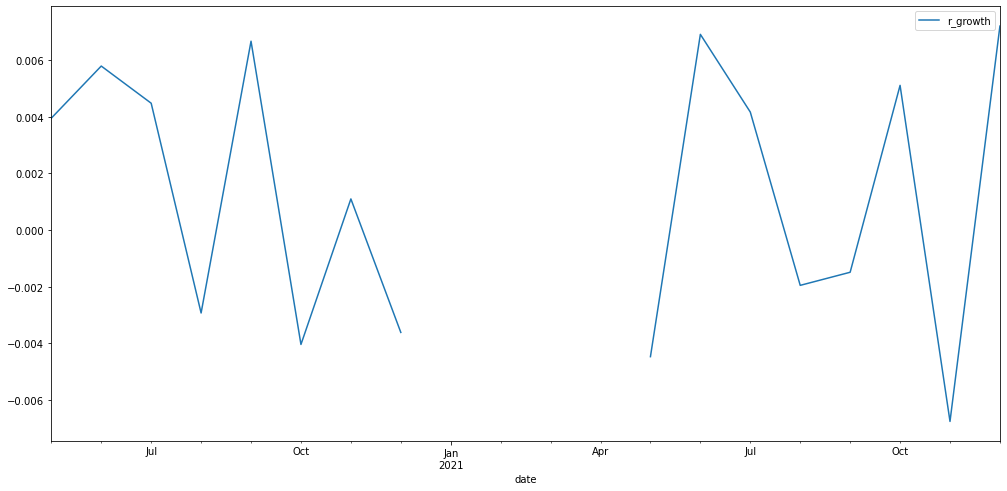

In [2510]:
df.groupby(pd.Grouper(key='date', freq='m'))['r_growth'].mean().plot(legend=True, figsize=(17,8))

<AxesSubplot:xlabel='date', ylabel='r_growth'>

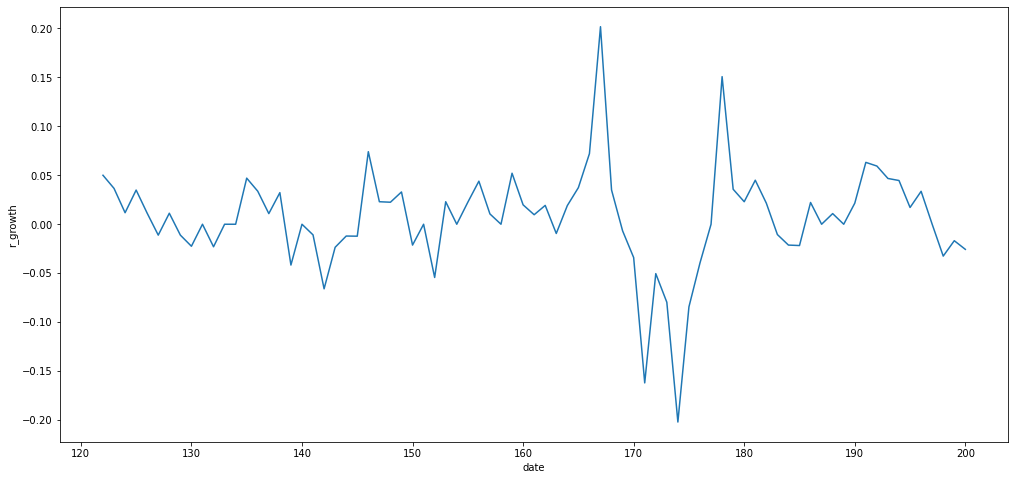

In [2511]:
plt.figure(figsize = (17,8))
sns.lineplot(x = df['date'].dt.dayofyear , y = 'r_growth', data = df.loc[(df['year'] == 2020) & (df['date'].dt.dayofyear >= 100)  & (df['date'].dt.dayofyear <= 200)])

In [2512]:
df.groupby(['date'])['r_growth'].mean()

date
2020-05-01    0.050000
2020-05-02    0.036585
2020-05-03    0.011765
2020-05-04    0.034884
2020-05-05    0.011236
                ...   
2021-12-27    0.058252
2021-12-28    0.036697
2021-12-29    0.017699
2021-12-30    0.017391
2021-12-31    0.017094
Name: r_growth, Length: 490, dtype: float64

## One chart to rule them all

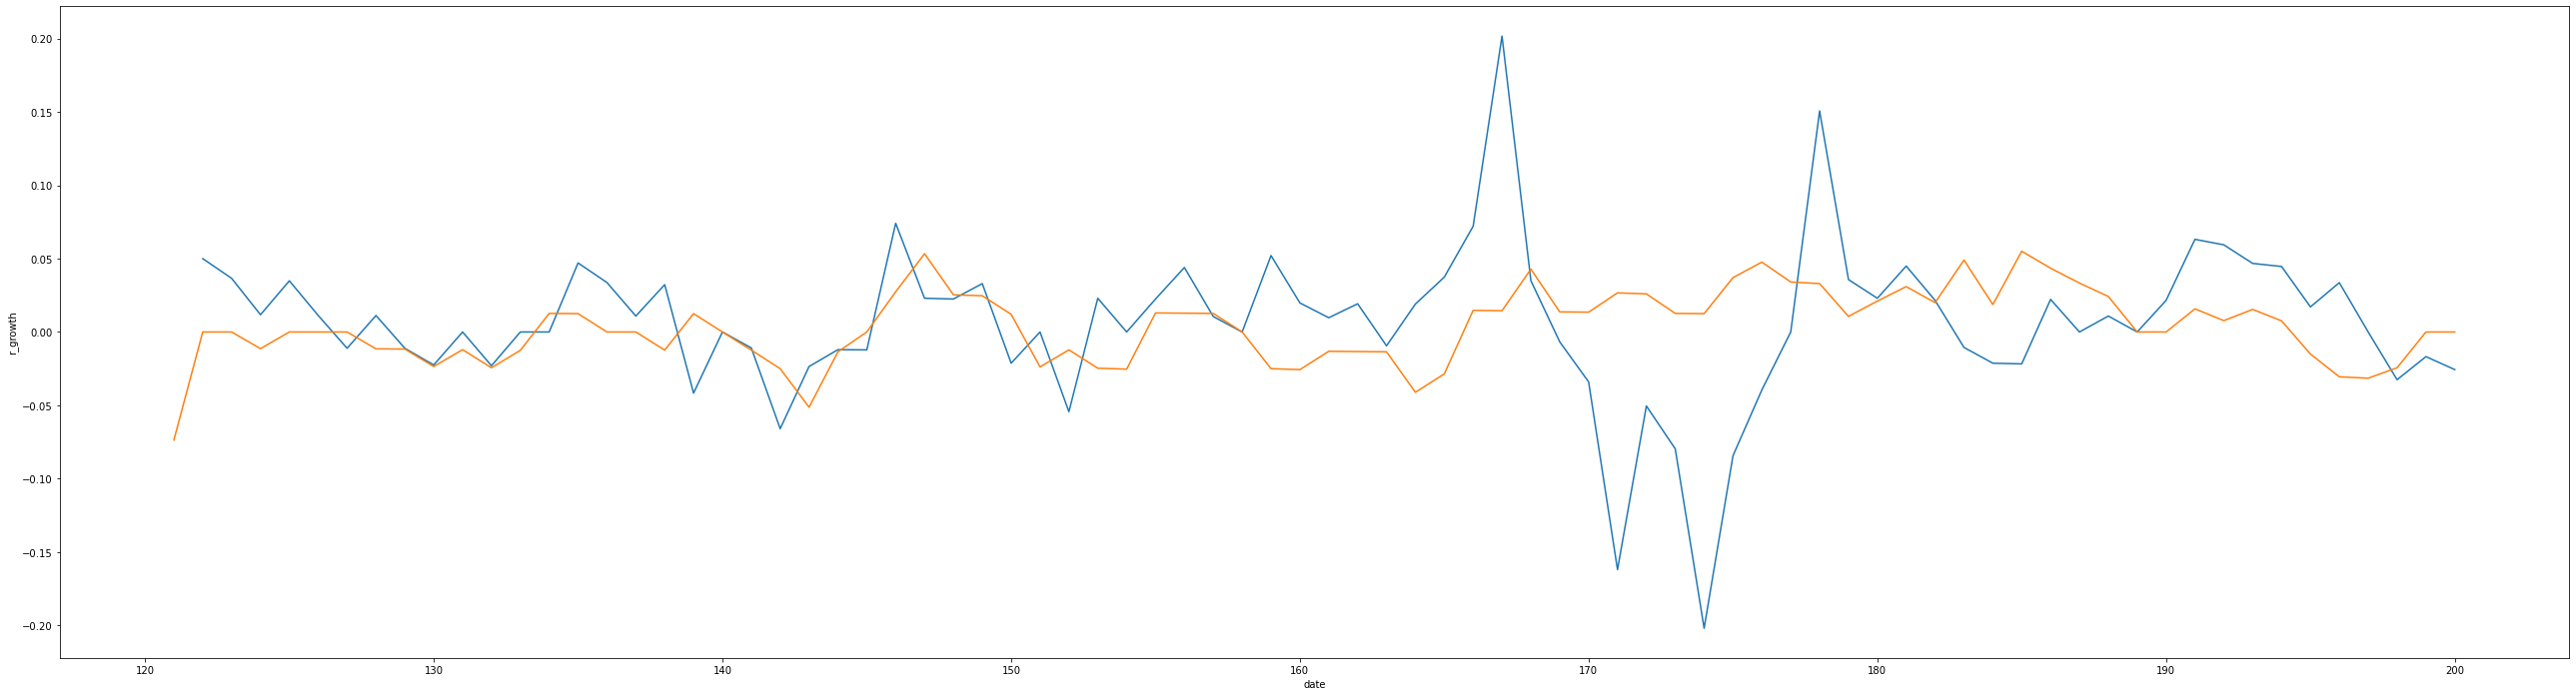

In [2513]:
plt.figure(figsize = (45,12))
r_growth_plot = sns.lineplot(x = df['date'].dt.dayofyear , y = 'r_growth', data = df.loc[(df['year'] == 2020) & (df['date'].dt.dayofyear >= 100)  & (df['date'].dt.dayofyear <= 200)])
r_growth_plot = sns.lineplot(x = df['date'].dt.dayofyear , y = 'r_growth', data = df.loc[(df['year'] == 2021) & (df['date'].dt.dayofyear >= 100)  & (df['date'].dt.dayofyear <= 200)])


In [2514]:
r_growth_plot 

<AxesSubplot:xlabel='date', ylabel='r_growth'>

## Single Charts for each year

Text(0, 0.5, 'Growth Rate')

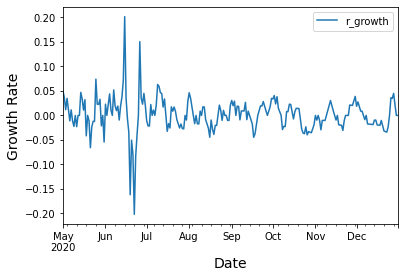

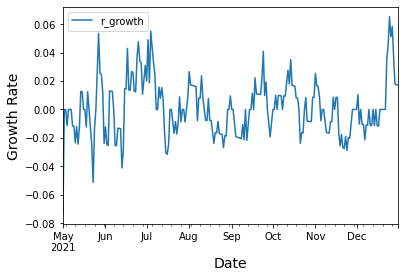

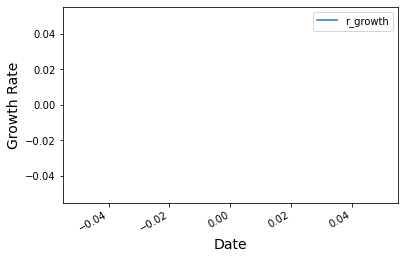

In [2515]:
df.loc[df['year'] == 2020].plot(x='date',y='r_growth')
plt.xlabel("Date",size=14)
plt.ylabel("Growth Rate",size=14)
df.loc[df['year'] == 2021].plot(x='date',y='r_growth')
plt.xlabel("Date",size=14)
plt.ylabel("Growth Rate",size=14)
df.loc[df['year'] == 2022].plot(x='date',y='r_growth')
plt.xlabel("Date",size=14)
plt.ylabel("Growth Rate",size=14)


# Hospitalization: Prognosis with LinearRegression

## For all data 

In [2516]:
hosp_lr = hosp.copy()

In [2517]:
hosp_lr['date']=hosp_lr['date'].map(dt.datetime.toordinal)

In [2518]:
y = hosp_lr['hcases']
X = hosp_lr.drop(['hcases'], axis=1)
# X already consists of numericals only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2519]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train)
x_normalized = transformer.transform(X_train)
print(x_normalized.shape)
x_normalized #this is an array
X_train = pd.DataFrame(x_normalized, columns=X_train.columns) #now we convert the array to a dataframe

(620, 3)


In [2520]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_test)
x_normalized = transformer.transform(X_test)
print(x_normalized.shape)
x_normalized #this is an array
X_test = pd.DataFrame(x_normalized, columns=X_test.columns) #now we convert the array to a dataframe

(156, 3)


In [2521]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [2522]:
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.6421697253073304

## For each year

### 2020

In [2523]:
hosp_2020 = hosp[(hosp.date.dt.year == 2020)].copy()

In [2524]:
hosp_2020['date']=hosp_2020['date'].map(dt.datetime.toordinal)

In [2525]:
y = hosp_2020['hcases']
X = hosp_2020.drop(['hcases'], axis=1)
# X already consists of numericals only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2526]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train)
x_normalized = transformer.transform(X_train)
print(x_normalized.shape)
x_normalized #this is an array
X_train = pd.DataFrame(x_normalized, columns=X_train.columns) #now we convert the array to a dataframe

(240, 3)


In [2527]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_test)
x_normalized = transformer.transform(X_test)
print(x_normalized.shape)
x_normalized #this is an array
X_test = pd.DataFrame(x_normalized, columns=X_test.columns) #now we convert the array to a dataframe

(61, 3)


In [2528]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.7216098347029509

### 2021

In [2529]:
hosp_2021 = hosp[(hosp.date.dt.year == 2021)].copy().reset_index().drop(['index'], axis=1)

In [2530]:
# in 2021 the vaccination started. So therefor I just look at the 2nd half of the year when most of the elderly had been vaccinated
hosp_2021 = hosp_2021.iloc[182:365]
# hosp_2021 = hosp_2021.iloc[0:181]

In [2531]:
hosp_2021['date']=hosp_2021['date'].map(dt.datetime.toordinal)

In [2532]:
y = hosp_2021['hcases']
X = hosp_2021.drop(['hcases'], axis=1)
# X already consists of numericals only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [2533]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train)
x_normalized = transformer.transform(X_train)
print(x_normalized.shape)
x_normalized #this is an array
X_train = pd.DataFrame(x_normalized, columns=X_train.columns) #now we convert the array to a dataframe

(142, 3)


In [2534]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_test)
x_normalized = transformer.transform(X_test)
print(x_normalized.shape)
x_normalized #this is an array
X_test = pd.DataFrame(x_normalized, columns=X_test.columns) #now we convert the array to a dataframe

(41, 3)


In [2535]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.8015414016042545

In [2536]:
# :( Just realized that all my data from the trainingset need to be from an earlier date than my testset
# and then I would also need to replace the column new cases with incidence or maybe even have both.

#### Compare with dates from January

In [2537]:
hosp_2022_jan = hosp[(hosp.date.dt.year == 2022)].copy().reset_index().drop(['index'], axis=1)

In [2538]:
hosp_2022_jan = hosp_2022_jan[hosp_2022_jan['date'].dt.month == 1]
hosp_2022_jan['date']=hosp_2022_jan['date'].map(dt.datetime.toordinal)

In [2539]:
y = hosp_2022_jan['hcases']
X = hosp_2022_jan.drop(['hcases'], axis=1)

In [2540]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X)
x_normalized = transformer.transform(X)
print(x_normalized.shape)
x_normalized #this is an array
X = pd.DataFrame(x_normalized, columns=X.columns) #now we convert the array to a dataframe

(31, 3)


In [2541]:
predictions = lm.predict(X)
r2_score(y, predictions)

-28.40022258311616

### 2022

In [2542]:
hosp_2022 = hosp[(hosp.date.dt.year == 2022)].copy()
hosp_2022['date']=hosp_2022['date'].map(dt.datetime.toordinal)

In [2543]:
y = hosp_2022['hcases']
X = hosp_2022.drop(['hcases'], axis=1)
# X already consists of numericals only

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [2544]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_train)
x_normalized = transformer.transform(X_train)
print(x_normalized.shape)
x_normalized #this is an array
X_train = pd.DataFrame(x_normalized, columns=X_train.columns) #now we convert the array to a dataframe

(88, 3)


In [2545]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_test)
x_normalized = transformer.transform(X_test)
print(x_normalized.shape)
x_normalized #this is an array
X_test = pd.DataFrame(x_normalized, columns=X_test.columns) #now we convert the array to a dataframe

(22, 3)


In [2546]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.8867749562117104

# Comparing cases 2021 and 2022

In [2547]:
t_testdata

,index,date,cases,rval,year
0,4,2020-03-06,757,2.34,2020
1,5,2020-03-07,984,2.56,2020
2,6,2020-03-08,1336,2.93,2020
3,7,2020-03-09,2020,3.13,2020
4,8,2020-03-10,2574,3.22,2020
...,...,...,...,...,...
771,775,2022-04-16,83543,0.89,2022
772,776,2022-04-17,94915,0.88,2022
773,777,2022-04-18,106658,0.92,2022
774,778,2022-04-19,124049,0.98,2022


In [2641]:
cases_2020 = t_testdata[(t_testdata['date'].dt.year == 2020) & (t_testdata['date'].dt.month >= 4) ].groupby(pd.Grouper(key='date', freq='d'))['cases'].agg(sum).reset_index()
cases_2021 = t_testdata[(t_testdata['date'].dt.year == 2021) & (t_testdata['date'].dt.month >= 4) ].groupby(pd.Grouper(key='date', freq='d'))['cases'].agg(sum).reset_index()


In [2642]:
cases_2020.drop(['date'], axis=1, inplace=True)
cases_2021.drop(['date'], axis=1, inplace=True)


In [2646]:
#perform two sample t-test with equal variances
stat, pval = stats.ttest_ind(a=cases_2020, b=cases_2021, equal_var=True)
print('Stat' + str(stat))
print('Stat' + str(pval))


Stat[-8.95914409]
Stat[5.10989219e-18]


In [2655]:
round(pval[0], 20)

5.11e-18

In [2551]:
cases_2020

,cases
0,404
1,342
2,345
3,300
4,290
...,...
179,18086
180,22339
181,18575
182,16287


In [2552]:
cases_2021

,cases
0,655
1,655
2,676
3,740
4,1038
...,...
179,38089
180,37520
181,34666
182,33152


In [2553]:
confidence_level = 0.95
degrees_freedom = len(cases_2020) - 1 
sample_mean = np.mean(cases_2020)

In [2554]:
sample_std_error = stats.sem(cases_2020) 
confidence_interval = stats.t.interval(confidence_level, 
                                             degrees_freedom, 
                                             sample_mean, 
                                             sample_std_error)

In [2555]:
confidence_interval

(array([7492.23949369]), array([10031.71702804]))